In [1]:
import sys
print(sys.executable)

sys.path.append('../../')
print(sys.path)

/home/mshunya/001_Project/002_QGen/001_Work/MakeResult/.env/bin/python
['/home/mshunya/.pyenv/versions/3.11.7/lib/python311.zip', '/home/mshunya/.pyenv/versions/3.11.7/lib/python3.11', '/home/mshunya/.pyenv/versions/3.11.7/lib/python3.11/lib-dynload', '', '/home/mshunya/001_Project/002_QGen/001_Work/MakeResult/.env/lib/python3.11/site-packages', '../../']


In [90]:
import pickle
import time
import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Batch
from IPython.display import display, Math
from qiskit import transpile, QuantumCircuit
from qiskit.quantum_info import Statevector
from scipy.optimize import minimize

from gqco.train import MyModel
from gqco.utils import fix_seed, arange_token
from gqco.data import generate_data, RandomGraphDatasetWithClone
from gqco.solve import solve_from_token, plot_from_dict, brute_solver, probs_to_result
from gqco.model import TransformerWithMoE
from gqco.quantum import coef_to_pauli, pauli_to_matrix, make_cudaq_operator
from gqco.task import GQCO

# import importlib
# def fun_reload(pkg):
#     module = importlib.import_module(pkg)
#     module = importlib.reload(module)
#     attrs = {attr: getattr(module, attr) for attr in dir(module)}
#     globals().update(attrs)

# fun_reload('gqco.quantum')
# fun_reload('gqco.model')

In [91]:
def data_from_adj(adj, args, num_clone, device):
    dataset = RandomGraphDatasetWithClone(adj, num_clone=num_clone, max_num_nodes=args.max_size, device=device)
    record = Batch.from_data_list(dataset)
    record['size'] = record['size'].tolist()[0]
    record['len'] = dataset.len()

    return adj, size, record

In [92]:
task_path = '../../model/taskobjects.pkl'
model_path = '../../model/merged_model.ckpt'


with open(task_path, 'rb') as f: 
    obj = pickle.load(f)
args = obj['args']
taskobj = GQCO(args)


model = TransformerWithMoE(args)
model = MyModel.load_from_checkpoint(model_path, model=model, task=taskobj, args=args)

## Problem

In [144]:
size = 3
num_clone = 20

adj = None
# adj = torch.tensor([
#     [0, 2, 1, 0, 2],
#     [0, 0, 2, 1, 0],
#     [0, 0, 0, 2, 0],
#     [0, 0, 0, 0, 1],
#     [0, 0, 0, 0, 0],
# ], dtype=torch.float)
# adj = torch.tensor([
#     [0, 2, 0, 1, 0, 2, 2],
#     [0, 0, 1, 3, 0, 1, 0],
#     [0, 0, 0, 3, 4, 0, 1],
#     [0, 0, 0, 0, 1, 0, 0],
#     [0, 0, 0, 0, 0, 1, 0],
#     [0, 0, 0, 0, 0, 0, 3],
#     [0, 0, 0, 0, 0, 0, 0]
# ], dtype=torch.float)
adj = torch.tensor([
    [0, 2, 0, 1, 0, 2, 2, 0, 0, 2],
    [0, 0, 1, 0, 0, 1, 0, 0, 2, 0],
    [0, 0, 0, 2, 2, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 1, 0, 0, 2, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 2, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 1, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
], dtype=torch.float)
adj /= torch.max(torch.abs(adj))
size = len(adj)

## GQCO

-- Token --
[301, 61, 61, 61, 931, 1313, 281, 552, 931, 382, 1124, 931, 382, 931, 950, 1559, 1675, 1618, 1656, 361]


-- Circuit --


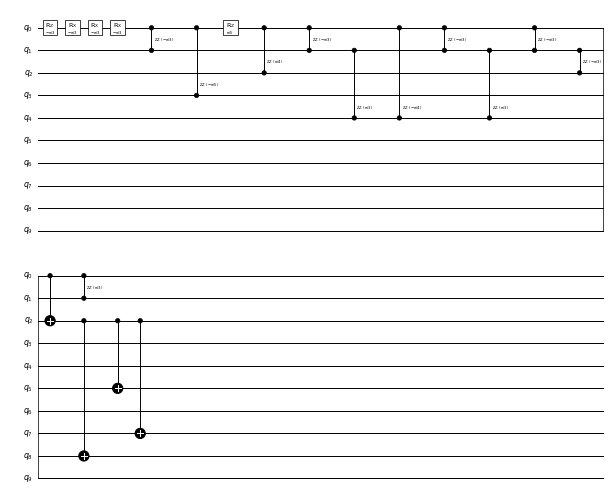



-- Transpiled circuit --


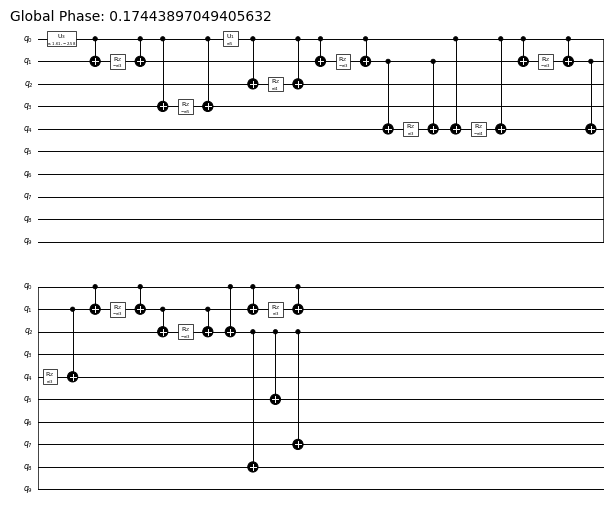

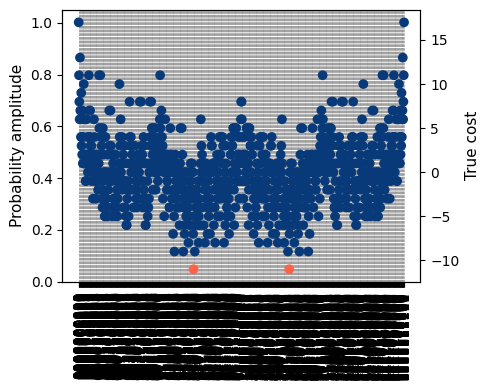

In [145]:
model.eval()

# seed = np.random.randint(1, 10000)
seed = 0

fix_seed(seed)
## Generate data
if adj is None:
    adj, size, record = generate_data(args.to(model.device), num_clone=num_clone, seed=seed, device=model.device, size=size)
else:
    adj, size, record = data_from_adj(adj, args, num_clone, model.device)

## Generate circuits
with torch.no_grad():
    out_tokens, probs_all, _, logits_all = model.forward(record, temperature=2.0)
tokens_list = [arange_token(t, args) for t in out_tokens.detach().tolist()]
energies = [taskobj.compute_energy(t, adj, args.num_shot) for t in tokens_list]

## Get the best
idx_min = energies.index(min(energies))
token_min = tokens_list[idx_min]
energy_min = energies[idx_min]

## Make result
dict_pred, dict_true, qc = solve_from_token(taskobj, token_min, adj, is_print=True, savefile=None)
plot_from_dict(dict_pred, dict_true, savefile=None)

In [146]:
with open('./outputs/pkl/500/501_GQCOCircuit.pkl', 'wb') as f:
    pickle.dump(qc.qc, f)

with open('./outputs/pkl/500/500_TrueCost.pkl', 'wb') as f:
    pickle.dump(dict_true, f)

## QAOA

In [147]:
layer_count=2

In [148]:
def make_qaoa_circuit(theta, adj, layer_count):
    num_qubit = len(adj)
    
    qc = QuantumCircuit(num_qubit)

    for i in range(num_qubit):
        qc.h(i)

    for ell in range(layer_count):

        for i in range(num_qubit):
            w = adj[i][i].cpu().tolist()
            if w != 0:
                qc.rz(w, i)

        for i in range(num_qubit-1):
            for j in range(i+1, num_qubit):
                w = adj[i, j].cpu().tolist()
                if w != 0:
                    qc.rzz(2*w*theta[ell], i, j)
                    # qc.cx(i, j)
                    # qc.rz(w, j)
                    # qc.cx(i, j)
            
        for k in range(num_qubit):
            qc.rx(2*theta[ell+layer_count], k)
    
    return qc

def get_state(qc):
    vector = Statevector(qc)
    array = []
    for v in vector:
        array.append(v)
    return np.array(array)

def objfun(theta):
    qc = make_qaoa_circuit(theta, adj, layer_count=layer_count)

    paulis, coeffs = coef_to_pauli(adj)
    H = np.diag(np.zeros(pow(2, size), dtype=np.complex128))
    for p, h in zip(paulis, coeffs):
        H += h * pauli_to_matrix(p)
    
    vector = get_state(qc)
    energy = np.vdot(vector, H @ vector).real

    return energy

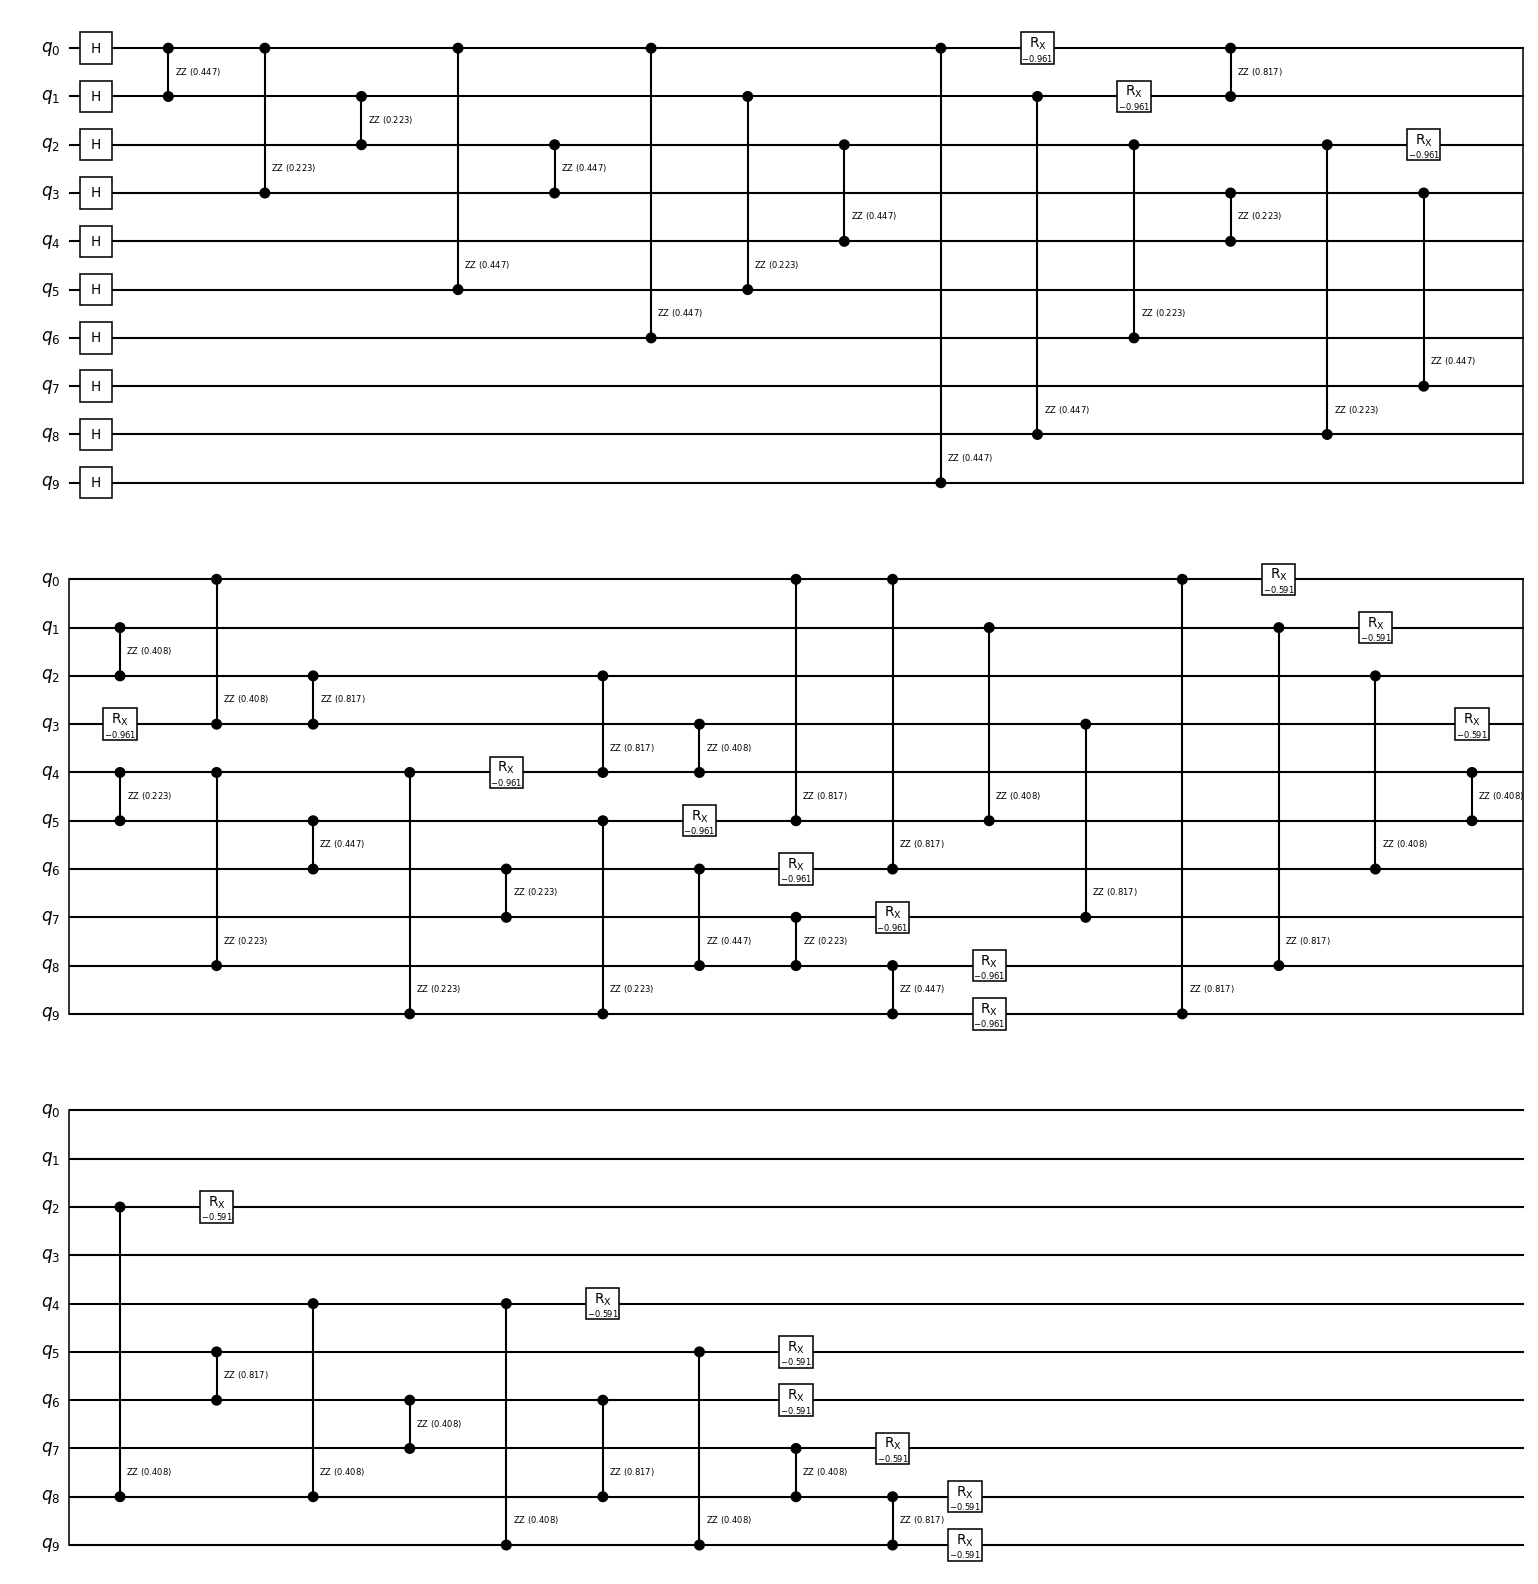

In [149]:
theta = np.random.uniform(-np.pi / 8, np.pi / 8, 2*layer_count)
result = minimize(objfun, theta, method='Nelder-Mead', options={'maxiter': 1000, 'fatol': 1e-5})
opt_theta = result.x

qc = make_qaoa_circuit(opt_theta, adj, layer_count=layer_count)
qc.draw(output='mpl', style='bw', scale=0.75, fold=30)

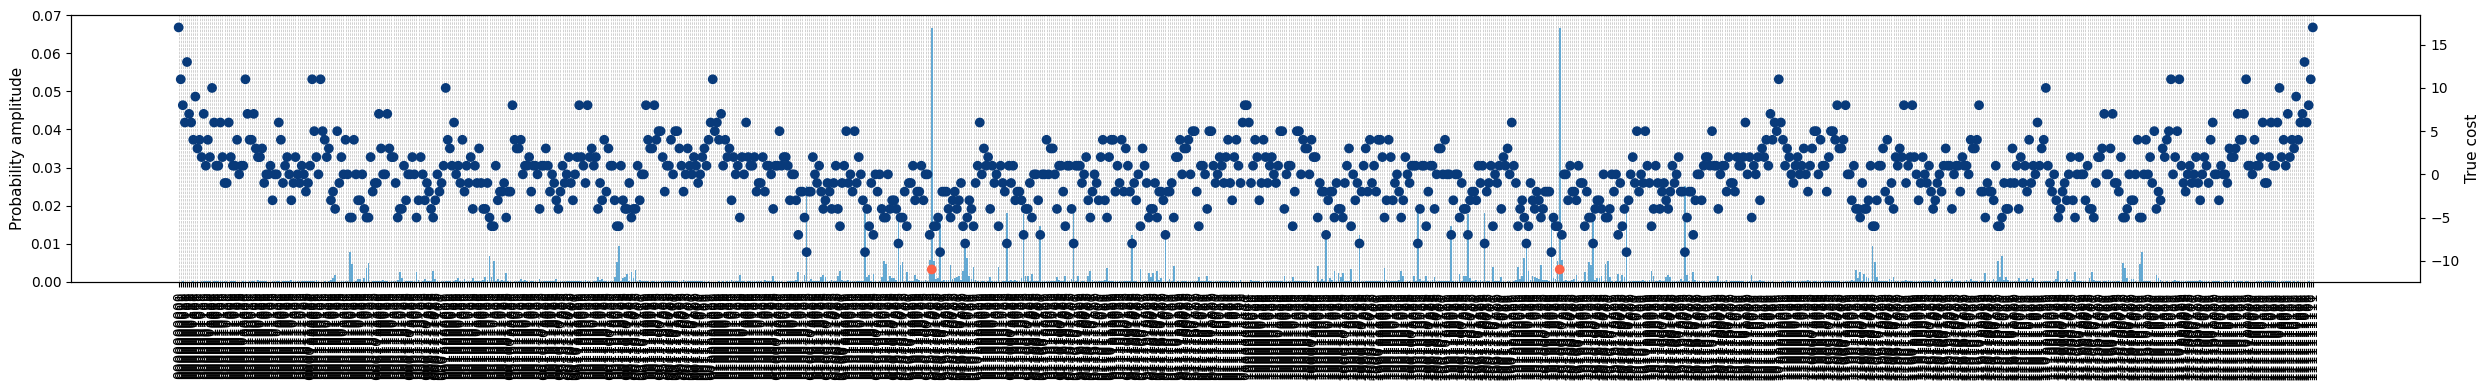

In [150]:
vec = get_state(qc)
probs = np.abs(vec)**2
dict_pred = probs_to_result(probs)
plot_from_dict(dict_pred, dict_true, savefile=None, figsize=(25,4))

In [151]:
with open('./outputs/pkl/500/502_QAOACircuit.pkl', 'wb') as f:
    pickle.dump(qc, f)